Autoencoders has an architecture which takes input and project it to lower dimension (using neural layers) and then try to reconstruct the original image using the projection. This is helpful for:
- Visualization (By projecting it to lower dimension, it can easily be plotted and hence visualize for getting insights)
- Clustering (Since image has to be reconstructed using the projection, projection learns good lower dimension representation of an image which can be helpful for clustering similar images)
- Image compression
- Image translation (From latent dimension when image is reconstructed, it can be another image [not input] so it can also help in image to image translation)

MNIST is used for training the architectures

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import wandb

# Helper

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def visualize_tensors():
    pass

def save_checkpoint(model, save_path):
    torch.save(model.state_dict(), save_path)
    
def load_checkpoint(model, save_path):
    model.load_state_dict(torch.load(save_path))
    return model

## Hyperparameters

In [3]:
batch_size = 64
input_vector = 784

# Load Data

In [4]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,], [0.5,])])
inv_transform = transforms.Compose([transforms.Normalize([0.,], [1/0.5,]),
                                   transforms.Normalize([-0.5,], [1.,])])
mnist_train = datasets.MNIST('data/', train = True, transform=transform, download=True)
mnist_val = datasets.MNIST('data/', train=False, transform=transform, download=True)
trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
validloader = DataLoader(mnist_val, batch_size=batch_size, num_workers=8, pin_memory=True)

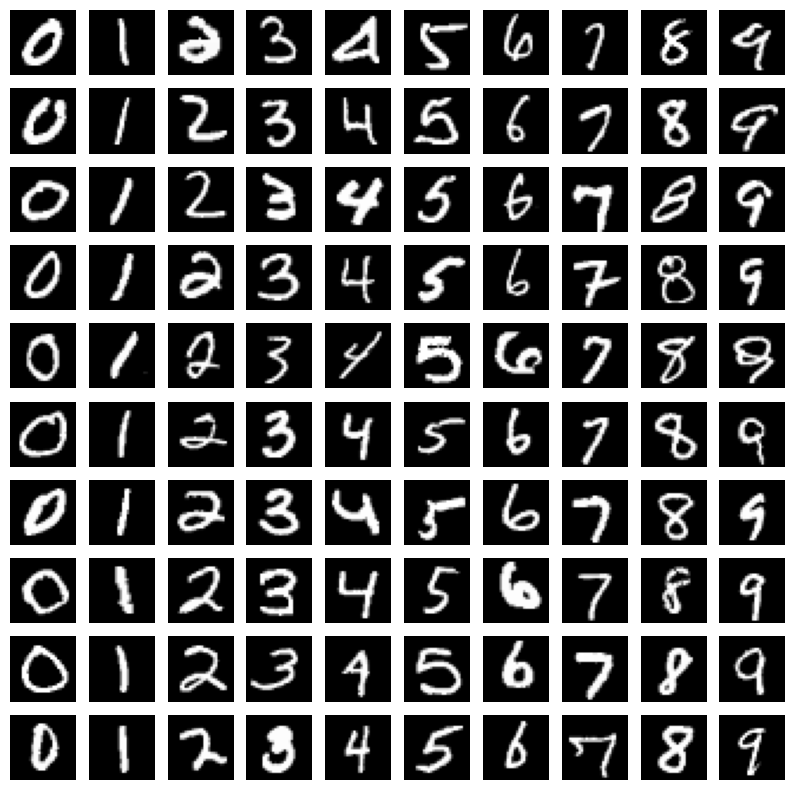

In [5]:
# Visualizing Data
train_images, train_labels = mnist_train.data, mnist_train.targets
unique_classes = np.unique(train_labels)
rows, cols = 10, len(unique_classes)
fig, axes = plt.subplots(rows, cols, figsize = (10,10))
i = 0
for _class in unique_classes:
    label_idx = np.where(train_labels == _class)[0]
    random_per_class = label_idx[np.random.choice(label_idx.shape[0], 10, replace = False)]
    for idx in random_per_class:
        img = train_images[idx]
        axes[i%10, i//10].imshow(img, cmap = 'gray')
        axes[i%10, i//10].axis('off')
        i+=1

# Vanilla Autoencoder

## Model

In [6]:
# Setting first experiment
wandb.init(project='Autoencoder', name="vanilla_encoder")
hidden_dim = [128, 64]
latent_dim = 2
learning_rate = 1e-02
num_epochs = 20
criterion = nn.MSELoss()
save_path = './saved_models/vanilla_auto.pt'

wandb.config = {
    'batch_size': 64,
    'hidden_dim': hidden_dim,
    'latent_dim': latent_dim,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'loss': 'mean_squared_error'
}
wandb.log({"data_visualize": fig})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniketthomas. Use `wandb login --relogin` to force relogin


In [7]:
class VanillaAutoencoder(nn.Module):
    def __init__(self, input_vector, hidden_units, latent_dim):
        super(VanillaAutoencoder, self).__init__()

        enc_list = []
        dec_list = []
        self.inp_dim = input_vector[0]
        all_units = input_vector + hidden_units + latent_dim
        for i in range(len(all_units) - 1):
            temp = [nn.Linear(all_units[i], all_units[i+1]),
                    nn.ReLU()]
            enc_list.extend(temp)

        self.encoder = nn.Sequential(*enc_list)
        
        for i in range(len(all_units) - 1, 0, -1):
            temp = [nn.Linear(all_units[i], all_units[i-1]),
                    nn.ReLU()]
            dec_list.extend(temp)

        self.decoder = nn.Sequential(*dec_list)

    def forward(self, x):
        x = x.view(-1, self.inp_dim)
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [8]:
van_autoencoder = VanillaAutoencoder([input_vector], hidden_dim, [latent_dim])
summary(van_autoencoder, (28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 2]                   130
|    └─ReLU: 2-6                         [-1, 2]                   --
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-7                       [-1, 64]                  192
|    └─ReLU: 2-8                         [-1, 64]                  --
|    └─Linear: 2-9                       [-1, 128]                 8,320
|    └─ReLU: 2-10                        [-1, 128]                 --
|    └─Linear: 2-11                      [-1, 784]                 101,1

In [9]:
def train_batch(imgs, model, criterion, optimizer, scaler, valid = False):
    optimizer.zero_grad()
    imgs, model = imgs.to(device, non_blocking = True), model.to(device)
    with torch.cuda.amp.autocast():
        out = model(imgs)
        imgs_flatten = imgs.view(-1, 784)
        batch_loss = criterion(out, imgs_flatten)
    if not valid:
        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
    return batch_loss.item()

def train(trainloader, validloader, model, criterion, optimizer, num_epochs, load_check = False, best_valid_metric = 0.0, 
          save_path = './saved_models/checkpoint.pt'):    
    # Load From checkpoing
    if load_check:
        model = load_checkpoint(model, save_path)

    scaler = torch.cuda.amp.GradScaler()
    train_losses, valid_losses = [], []
    for epoch in range(num_epochs+1):
        batch_loss = 0.0
        model.train()
        pbar = tqdm(trainloader, total = len(trainloader), leave = False)
        for imgs, _ in pbar:
            imgs = imgs.to(torch.float32)
            current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler)
            batch_loss += current_batch_loss
            pbar.set_postfix(train_loss = current_batch_loss)

        epoch_train_loss = batch_loss / len(trainloader)
        train_losses.append(epoch_train_loss)

        # Calculating for Valid data
        batch_loss = 0.0
        model.eval()
        pbar = tqdm(validloader, total = len(validloader), leave = False)
        with torch.no_grad():
            for imgs, _ in pbar:
                imgs = imgs.to(torch.float32)
                current_batch_loss = train_batch(imgs, model, criterion, optimizer, scaler, valid = True)
                batch_loss += current_batch_loss
                pbar.set_postfix(valid_loss = current_batch_loss)

        epoch_valid_loss = batch_loss / len(validloader)
        valid_losses.append(epoch_valid_loss)
        
        # Checkpoint
        if epoch_valid_loss < best_valid_metric:
            print('#### Saving ####')
            save_checkpoint(model, save_path)
            best_valid_metric = epoch_valid_loss
            
        wandb.log({'train_loss': epoch_train_loss, 'valid_loss': epoch_valid_loss})
        print(f"{'*'*10} EPOCH {epoch:2}/{num_epochs} {'*'*10}")
        print(f'''{"#"*33}
Train Loss: {epoch_train_loss:5.3f}
Valid Loss: {epoch_valid_loss:5.3f}
{"#"*33}''')
    return train_losses, valid_losses

In [10]:
optimizer = optim.AdamW(van_autoencoder.parameters(), lr = learning_rate)
train_losses, valid_losses = train(trainloader, validloader, van_autoencoder, criterion, optimizer, num_epochs, 
                                   best_valid_metric=999999, save_path=save_path)

#### Saving ####
********** EPOCH  0/20 **********
#################################
Train Loss: 0.926
Valid Loss: 0.926
#################################


********** EPOCH  1/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  2/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


#### Saving ####
********** EPOCH  3/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  4/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  5/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  6/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  7/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  8/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH  9/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 10/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 11/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 12/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


#### Saving ####
********** EPOCH 13/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 14/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 15/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 16/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 17/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 18/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 19/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


********** EPOCH 20/20 **********
#################################
Train Loss: 0.925
Valid Loss: 0.926
#################################


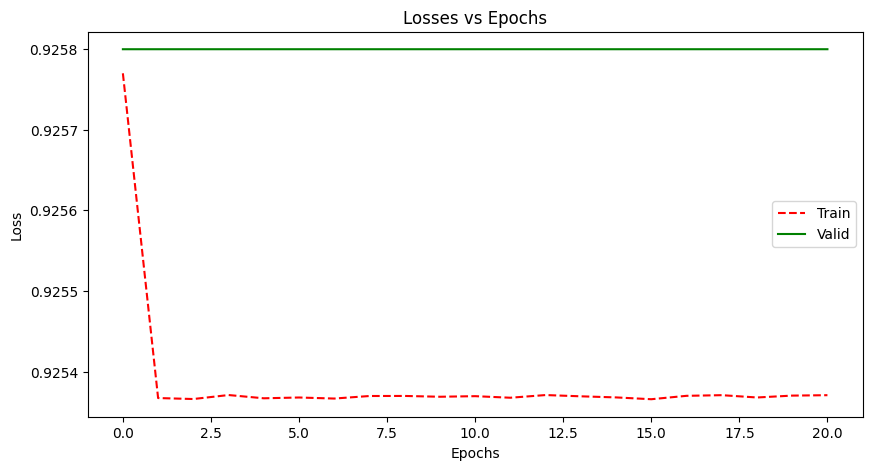

In [17]:
plt.figure(figsize = (10,5))
plt.title('Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, 'r--', label = 'Train')
plt.plot(valid_losses, 'g-', label = 'Valid')
plt.legend()
plt.show()